In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import cv2
import cv2 as cv
import os
import pathlib
import sys
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torchmetrics
from Dataloaders import supervised_loader, test_loader, unsupervised_loader, supervised_train_transform, test_transform, uda_train_transform, geometrical_transform

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [38]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)


In [4]:
LEARNING_RATE = 3e-5
BATCH_SIZE = 4
UNSUP_BATCH_SIZE = 8
NUM_EPOCHS = 50
NUM_WORKERS = 2
IMAGE_HEIGHT = 736 
IMAGE_WIDTH = 1280 
PIN_MEMORY = True
LOAD_MODEL = False
LAMBDA = 0.5
TRAIN_IMG_DIR = "segmentation_data/train_imgs"
TRAIN_MASK_DIR = "segmentation_data/train_masks"
VAL_IMG_DIR = "segmentation_data/val_imgs"
VAL_MASK_DIR = "segmentation_data/val_masks"
UNSUPERVISED_DIR = "unlabelled"

In [6]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
lambda1 = lambda epoch: 0.9 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
scaler = torch.cuda.amp.GradScaler()

In [7]:
## loading dataloaders

train_data_loader = supervised_loader(image_dir = TRAIN_IMG_DIR, mask_dir= TRAIN_MASK_DIR,
                                      transform=supervised_train_transform, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,
                                      shape = (IMAGE_WIDTH, IMAGE_HEIGHT))

val_data_loader = supervised_loader(image_dir = VAL_IMG_DIR, mask_dir= VAL_MASK_DIR,
                                      transform=test_transform, batch_size=BATCH_SIZE, shuffle=False, num_workers = 4,
                                      shape = (IMAGE_WIDTH, IMAGE_HEIGHT))
uda_data_loader = unsupervised_loader(image_dir = UNSUPERVISED_DIR,
                                      transform=uda_train_transform, geometrical_transform= geometrical_transform, 
                                      batch_size=UNSUP_BATCH_SIZE, shuffle=True, num_workers = 4,
                                      shape = (IMAGE_WIDTH, IMAGE_HEIGHT))

In [8]:
label_train_iter = iter(train_data_loader)

In [9]:
iou_fn = torchmetrics.classification.JaccardIndex(task = 'binary', threshold = 0., num_classes = 2)

epochs = (range(NUM_EPOCHS))

val_loss = []
train_loss = []

train_iou = []
val_iou = []

max_val_iou = 0
for epoch in epochs:
    
    total_val_loss = 0
    total_train_loss = 0
    total_train_iou = 0
    total_val_iou = 0
    
    ## training part

    for batch_idx, (un_img, un_aug_img) in enumerate(uda_data_loader):
        ## UNSUPERVISED DATA
        un_img = un_img.to(device=DEVICE)
        un_aug_img = un_aug_img.to(device=DEVICE)
        
        
        ## SUPERVISED DATA
        try:
            data ,targets = next(label_train_iter)
        except StopIteration:
            label_train_iter = iter(train_data_loader)
            data, targets = next(label_train_iter)
        
        data = data.to(device = DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            ## unsupervised part for consistency loss
            ref_mask = model(un_img)
            aug_mask = model(un_aug_img)
            consistency_loss = loss_fn(ref_mask, aug_mask)
            
            ## supervised part
            predictions = model(data)
            sup_loss = loss_fn(predictions, targets)
        
        ## CALCULATING NET LOSS
        loss = sup_loss + LAMBDA*consistency_loss    

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iou_train = iou_fn(predictions.to("cpu"), ((targets > 0)*1).to("cpu"))
        total_train_iou += iou_train.item()
        # loop.set_postfix(loss=loss.item(), iou_loss = iou_train_loss)
        total_train_loss += loss.item()
        x = optimizer.param_groups[0]["lr"]
        print(f" Epoch - {epoch+1}, Step - {batch_idx+1}/{len(uda_data_loader)}, Lr - {x}, Training_Loss - {round(total_train_loss/(batch_idx+1), 4)}, Train_mIOU - {round(total_train_iou/(batch_idx+1), 4)}", end="\r")
    total_train_loss = total_train_loss/(batch_idx+1)
    total_train_iou = total_train_iou/(batch_idx+1)
    train_loss.append(total_train_loss)
    train_iou.append(total_train_iou)
    scheduler.step()
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_data_loader):
            data = data.to(device=DEVICE)
            targets = targets.float().unsqueeze(1).to(device=DEVICE)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_val_loss += loss.item()
            iou_val = iou_fn(predictions.to("cpu"), ((targets > 0)*1).to("cpu"))
            total_val_iou += iou_val.item()
            # val_loop.set_postfix(val_loss=loss.item(), iou_loss = iou_val_loss)
    total_val_loss = total_val_loss/(batch_idx+1)
    total_val_iou = total_val_iou/(batch_idx+1)
    val_loss.append(total_val_loss)
    val_iou.append(total_val_iou)
    print(f" Epoch - {epoch+1}, Training_Loss - {round(total_train_loss, 4)}, Train_mIOU - {round(total_train_iou, 4)}, Validation_Loss - {round(total_val_loss, 4)}, val_mIOU - {round(total_val_iou, 4)}")

    if total_val_iou>max_val_iou:
        print(f"Validation mIOU increased from {max_val_iou} to {total_val_iou}, Saving Model....")
        torch.save(model.state_dict(), "best_model_uda.ckpt")
        max_val_iou = total_val_iou

 Epoch - 1, Training_Loss - -9.895, Train_mIOU - 0.9011, Validation_Loss - 0.0569, val_mIOU - 0.9643
Validation mIOU increased from 0 to 0.964347585439682, Saving Model....
 Epoch - 2, Training_Loss - -42.1438, Train_mIOU - 0.9222, Validation_Loss - 0.0234, val_mIOU - 0.9751
Validation mIOU increased from 0.964347585439682 to 0.9751435422897339, Saving Model....
 Epoch - 3, Training_Loss - -81.5435, Train_mIOU - 0.9673, Validation_Loss - 0.016, val_mIOU - 0.9806
Validation mIOU increased from 0.9751435422897339 to 0.9805860185623169, Saving Model....
 Epoch - 4, Training_Loss - -127.2185, Train_mIOU - 0.9792, Validation_Loss - 0.0162, val_mIOU - 0.9819
Validation mIOU increased from 0.9805860185623169 to 0.9818973982334137, Saving Model....
 Epoch - 5, Training_Loss - -176.9852, Train_mIOU - 0.9784, Validation_Loss - 0.0138, val_mIOU - 0.9832
Validation mIOU increased from 0.9818973982334137 to 0.983221845626831, Saving Model....
 Epoch - 6, Training_Loss - -229.2513, Train_mIOU - 0.98

KeyboardInterrupt: 

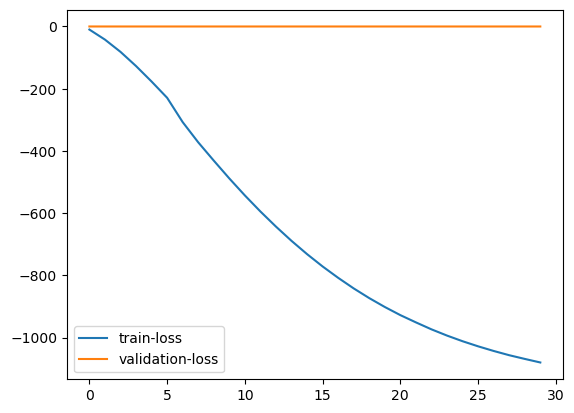

In [10]:
plt.plot(train_loss, label="train-loss")
plt.plot(val_loss, label="validation-loss")
plt.legend()
plt.savefig("results/uda_unet_loss.png")

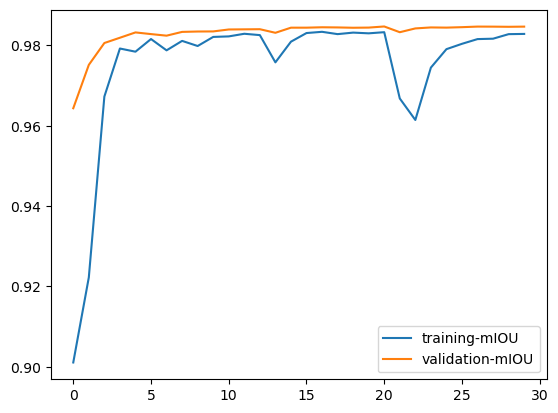

In [11]:
plt.plot(train_iou, label = "training-mIOU")
plt.plot(val_iou, label = "validation-mIOU")
plt.legend()
plt.savefig("results/uda_unet_miou.png")

In [41]:
chkpt = torch.load("best_model_uda.ckpt", map_location=DEVICE)
model.load_state_dict(chkpt)
model.eval()
print("Evaluation mode on")

Evaluation mode on


In [63]:
dest = "generated_unets"
cnt = 1
for i in tqdm(os.listdir(UNSUPERVISED_DIR)):
    img_path = UNSUPERVISED_DIR + "/" + i
    orig_img = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (IMAGE_WIDTH, IMAGE_HEIGHT))
    trans_img = test_transform(image = orig_img)["image"]
    trans_img = trans_img.to(DEVICE).unsqueeze(0)
    cv2.imwrite(dest+"/img/" + str(cnt).zfill(4) + ".png", cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(dest+"/unet_mask/" + str(cnt).zfill(4) + ".png", np.uint8(model(trans_img).squeeze().detach().cpu().numpy()>0)*255)
    cnt+=1

100%|██████████| 7000/7000 [13:28<00:00,  8.65it/s]


True

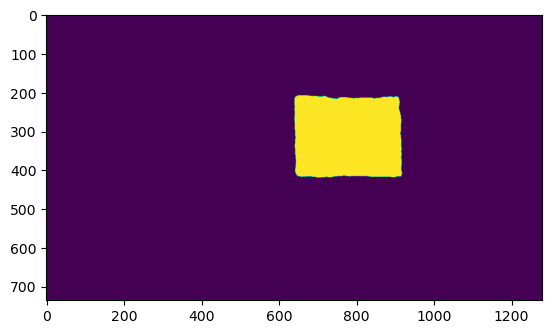

In [59]:
plt.imshow(np.uint8(model(trans_img).squeeze().detach().cpu().numpy()>0))